# 1. Describe the data
- It has 47 rows.
- There are 2 variables:
    - temp: log temperature
    - light: log light intensity
- The data includes the logarithms of surface temperature and light intensity for 47 stars in the CYG OBI star cluster, located in the direction of Cygnus. 

# 2. Load packages and data

In [2]:
%%capture
pip install faraway

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import faraway.utils
np.set_printoptions(suppress=True)

In [5]:
import faraway.datasets.star
star = faraway.datasets.star.load()
star.head()

,temp,light
0,4.37,5.23
1,4.56,5.74
2,4.26,4.93
3,4.56,5.74
4,4.30,5.19


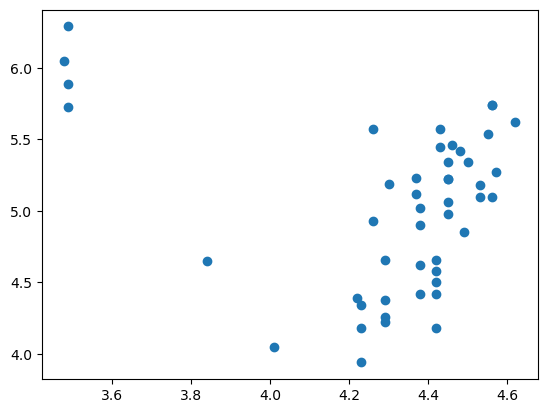

In [6]:
plt.scatter(star.temp, star.light);

- There seems to be a positive correlation between temperature and light intensity, but four stars deviate from this pattern.
- We fit a linear regression model and add the fitted line to the plot.

# 3. Linear Regression

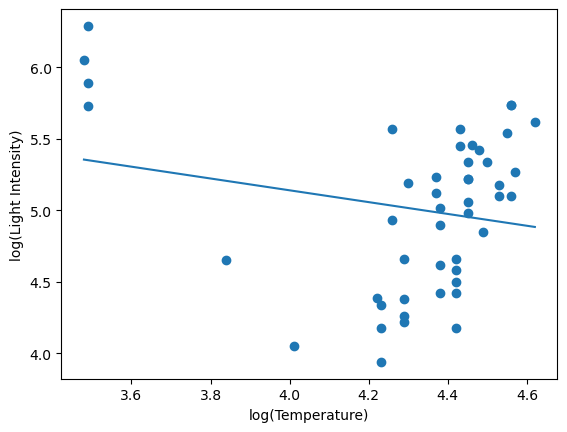

In [7]:
lmod = smf.ols('light ~ temp', star).fit() 
xr = np.array([np.min(star.temp), np.max(star.temp)]) # for x-axis
plt.plot(xr, lmod.params.iat[0] + lmod.params.iat[1]*xr)
plt.scatter(star.temp, star.light)
plt.xlabel("log(Temperature)"); plt.ylabel("log(Light Intensity)");

- This line doesn’t align with most of the data because it attempts to fit the four outlier points.

# 4. Diagnosis

- We check whether the outlier test detects these points:

In [8]:
stud = lmod.get_influence().resid_studentized_external
np.min(stud), np.max(stud)

(-2.0493927293780576, 1.9058472017663173)

- No outliers are detected, even though they are clearly visible in the plot. The four stars in the upper left are giants.
- We fit OLS without four stars

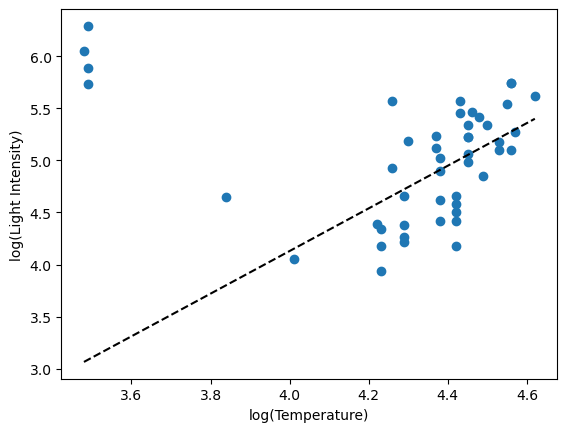

In [9]:
lmodr = smf.ols('light ~ temp',star[star.temp > 3.6]).fit() 
plt.plot(xr, lmodr.params.iat[0] + lmodr.params.iat[1]*xr, 'k--')
plt.scatter(star.temp, star.light)
plt.xlabel("log(Temperature)"); plt.ylabel("log(Light Intensity)");

- This example highlights the issue of multiple outliers.
- While we can identify and address these problems visually in this case, doing so becomes much more challenging with higher-dimensional data.

# 5. Robust Regression

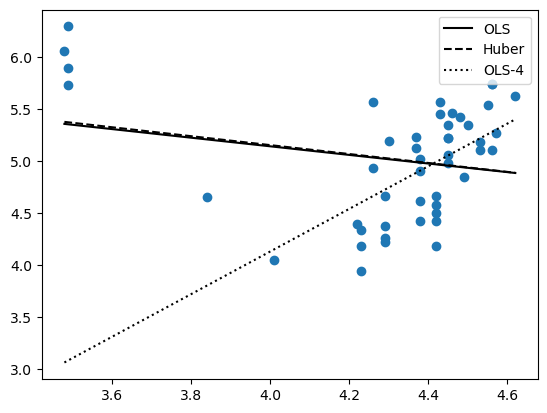

In [10]:
X = lmod.model.wexog
gs2 = sm.RLM(star.light, X).fit()
gs3 = smf.ols('light ~ temp', star.loc[star.temp > 3.6,:]).fit()
plt.scatter(star.temp, star.light, label = None)
xr = np.array([min(star.temp), max(star.temp)])
plt.plot(xr, lmod.params.iat[0] + lmod.params.iat[1]*xr,'k-', label="OLS")
plt.plot(xr, gs2.params.iat[0] + gs2.params.iat[1]*xr,'k--', label="Huber")
plt.plot(xr, gs3.params.iat[0] + gs3.params.iat[1]*xr,'k:', label="OLS-4")
plt.legend();

- The four stars on the right are atypical, and we might prefer the model to fit the rest of the data where light intensity increases with temperature.
- Unfortunately, the Huber estimator doesn’t recognize these stars as outliers and is similar to the least squares estimator.
- We’ve added a least squares fit excluding the four stars, which aligns more with our expectations.
- While we can manually adjust the plot in this example, identifying such issues in higher dimensions is more challenging. An automated method to detect and exclude these points is needed.
- The breakdown point of an estimator is the highest percentage of bad data it can handle before failing. These bad points are often called contaminated data. Resistant estimators have higher breakdown points, with a maximum of 50%, as more than half bad data can’t be tolerated. In the star example, even a small amount of contamination caused the Huber estimator to fail.
- For univariate data, the median is a highly robust estimator with a breakdown point of 50%. While one might think the LAD estimator serves as the regression equivalent of the median, it fails in cases like the star data. The Theil-Sen estimator is a better counterpart to the median and can be computed using the following procedure:
    - Compute the slopes of the lines connecting all pairs of points in the data.
    - The estimated slope, $\hat{β}$ is the median of these slopes.
    - The estimated intercept is given by the median of the values $y_i - \hat{β} x_i$
- The procedure requires the predictor to be a two-dimensional matrix, even if it has only one column in this example. This allows for generalization to higher-dimensional predictors by fitting planes instead of lines.

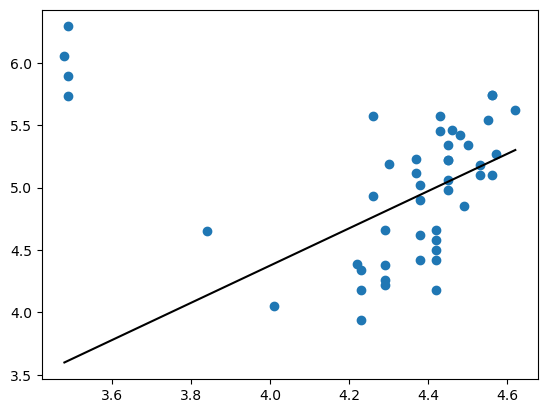

In [11]:
from sklearn.linear_model import TheilSenRegressor
X = np.reshape(star.temp.array,(-1,1)) # make two dimensions
y = star.light
reg = TheilSenRegressor(random_state=0).fit(X,y)
plt.scatter(star.temp, star.light)
plt.plot(xr, reg.intercept_ + reg.coef_*xr,'k-');

- The estimator effectively captures the trend in most of the data.
- While it’s possible to compute a confidence interval using percentiles from the paired slopes, this feature isn’t available in TheilSenRegressor.
- The estimator, with a breakdown point of 29.3%, is highly resistant. For larger samples, especially in higher dimensions, it’s necessary to economize computation by using a random sample of point pairs.
- The Random Sample Consensus (RANSAC) method, originally developed for image processing, can also be applied to regression problems. The procedure involves:
    - Choose a random sample that is just large enough to estimate the parameters. For univariate regression, only two data points are necessary.
    - Calculate the absolute values of the residuals. Residuals that are smaller than a specified threshold are considered inliers.
- We use random sampling to maximize the number of inliers. For small datasets, we can check all subsets, but for larger ones, random sampling is necessary. This process may not always find the optimal solution and is somewhat random. A common threshold is the median absolute deviation of the response values.

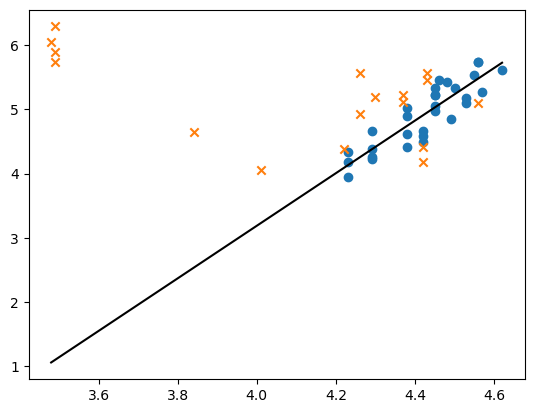

In [13]:
from sklearn.linear_model import RANSACRegressor
reg = RANSACRegressor().fit(X,y)
i = reg.inlier_mask_
plt.scatter(star.temp[i], star.light[i]) # inlier
plt.scatter(star.temp[~i], star.light[~i], marker='x') # outlier
plt.plot(xr, reg.estimator_.intercept_ + reg.estimator_.coef_*xr, 'k-');

- Inliers are separated from outliers. However, many observations that aren’t extremely deviant are still labeled as ‘outliers.’ We could avoid this by selecting a higher threshold, but it’s challenging to do so without hindsight.
- A major drawback of the RANSAC estimator is that it doesn’t provide standard errors or other statistical inference necessities. The algorithm’s complexity makes it difficult to derive these properties mathematically. While bootstrap methods could be used to add these features, they require recomputing the estimate many times, which is impractical for RANSAC. Alternatively, RANSAC can be seen as a method for identifying outliers and estimating parameters without requiring inference.
- Least trimmed squares (LTS) is similar to RANSAC but minimizes the sum of squares of the (q) smallest residuals, where (q) is less than (n) and indicates sorting. LTS has a high breakdown point, tolerating many outliers based on the choice of (q). Unlike RANSAC, which uses a threshold, LTS specifies the number of outliers to defend against. Additionally, LTS uses a least squares criterion on most of the data, offering smoother properties than RANSAC.